In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pywt
import urllib.request
import zipfile
import os
import optuna
from optuna.samplers import TPESampler
from functools import partial
from scipy.io import arff
import shap
from aux_functions import timeseries_to_pandas
from aux_functions import pandas_to_numpy
import seaborn as sns

# Configurações
plt.style.use('ggplot')
np.random.seed(42)

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(shap.__version__)
print(pywt.__version__)

0.45.0
1.8.0


In [3]:
# pip install pywavelets

## Tratamento inicial dos dados

In [4]:
#Read data
data_train = {}
data_test = {}

for i in range(1,7):
    data_train[i] = arff.loadarff(os.path.join('SelfRegulationSCP1',
                                               f'SelfRegulationSCP1Dimension{i}_TRAIN.arff'))[0]
    data_test[i] = arff.loadarff(os.path.join('SelfRegulationSCP1',
                                               f'SelfRegulationSCP1Dimension{i}_TEST.arff'))[0]
    
#Convert to pandas dataframes
df_train = timeseries_to_pandas(data_train)
df_test = timeseries_to_pandas(data_test)

#Convert to numpy arrays
X_train, y_train = pandas_to_numpy(df_train)
X_test, y_test = pandas_to_numpy(df_test)



# Convertendo de bytes para string
y_train = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in y_train])
y_test = np.array([y.decode('utf-8') if isinstance(y, bytes) else y for y in y_test])

label_map = {'negativity': 0, 'positivity': 1}

y_train = np.array([label_map[y] for y in y_train])
y_test = np.array([label_map[y] for y in y_test])


#Create folder structure and save the arrays
if not os.path.exists(os.path.join('Datasets_clean', 'SelfRegulationSCP1')):
    os.makedirs(os.path.join('Datasets_clean', 'SelfRegulationSCP1'))

np.save('Datasets_clean/SelfRegulationSCP1/X_train', X_train)
np.save('Datasets_clean/SelfRegulationSCP1/y_train', y_train)
np.save('Datasets_clean/SelfRegulationSCP1/X_test', X_test)
np.save('Datasets_clean/SelfRegulationSCP1/y_test', y_test)

## Leitura dos  dados processados

In [4]:
X_train = np.load('Datasets_clean/SelfRegulationSCP1/X_train.npy')
y_train = np.load('Datasets_clean/SelfRegulationSCP1/y_train.npy')  
X_test = np.load('Datasets_clean/SelfRegulationSCP1/X_test.npy')    
y_test = np.load('Datasets_clean/SelfRegulationSCP1/y_test.npy')

## Análise descritiva

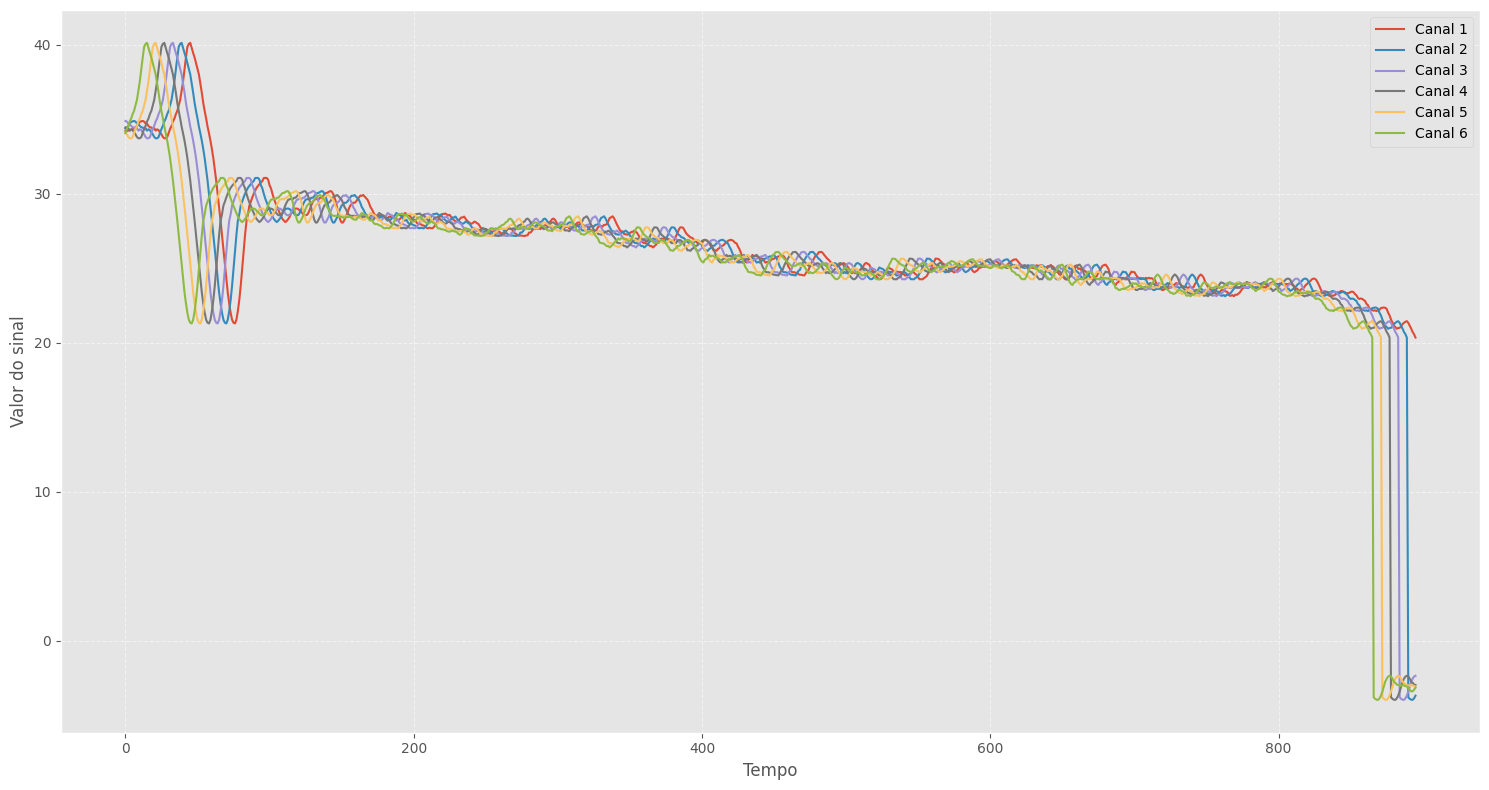

In [5]:
# Média por canal ao longo das amostras
mean_per_channel = X_train.mean(axis=0)  # (n_canais, n_tempo)

plt.figure(figsize=(15, 8))

n_canais = mean_per_channel.shape[0]

for i in range(n_canais):
    plt.plot(mean_per_channel[i], label=f'Canal {i+1}')

# plt.title('Série Temporal Média por Canal - SELFREGULATIONSCP1', fontsize=14)
plt.xlabel('Tempo')
plt.ylabel('Valor do sinal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


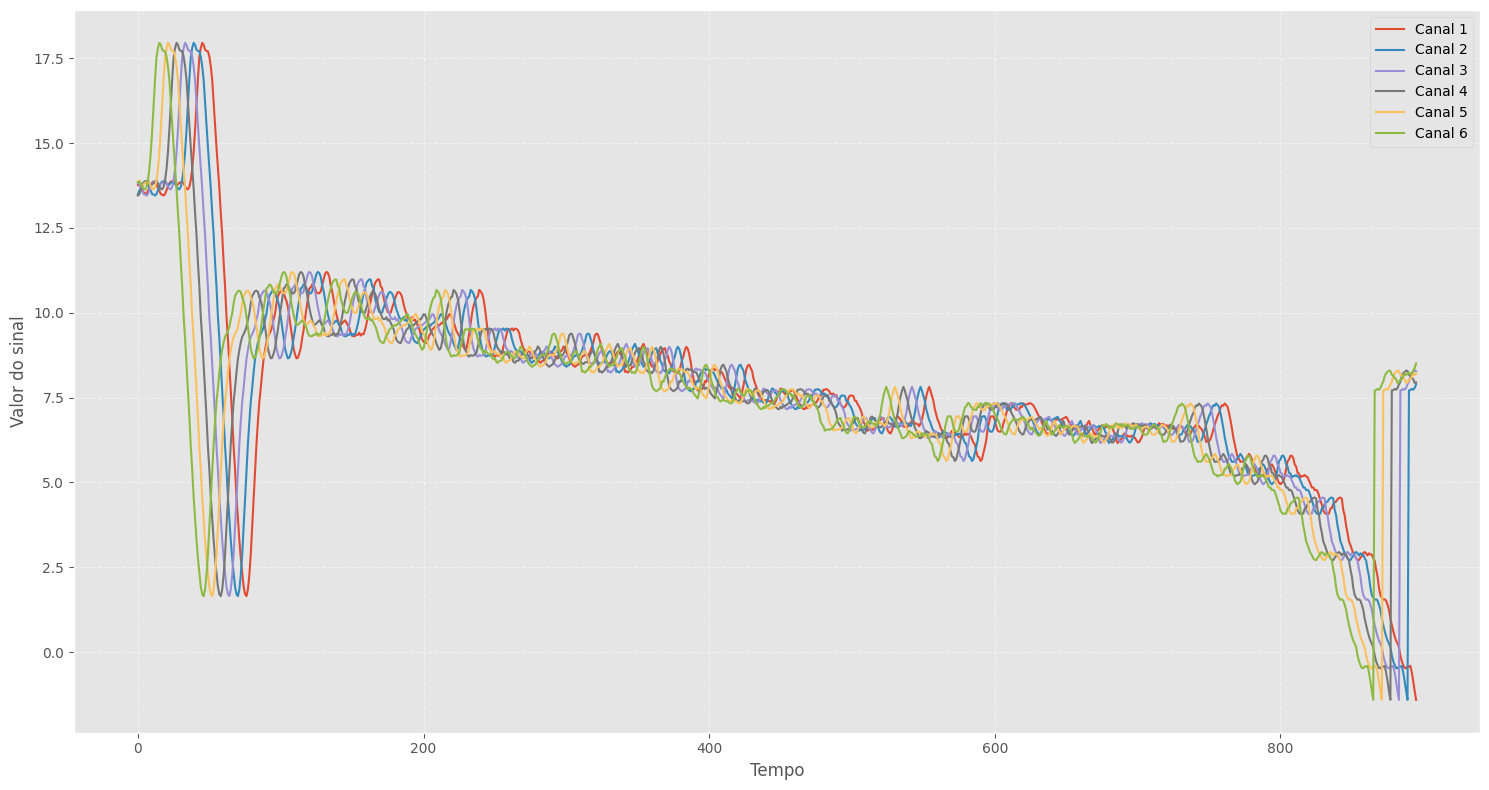

In [6]:
# Média por canal ao longo das amostras
mean_per_channel = X_test.mean(axis=0)  # (n_canais, n_tempo)

plt.figure(figsize=(15, 8))

n_canais = mean_per_channel.shape[0]

for i in range(n_canais):
    plt.plot(mean_per_channel[i], label=f'Canal {i+1}')

# plt.title('Série Temporal Média por Canal - SELFREGULATIONSCP1', fontsize=14)
plt.xlabel('Tempo')
plt.ylabel('Valor do sinal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

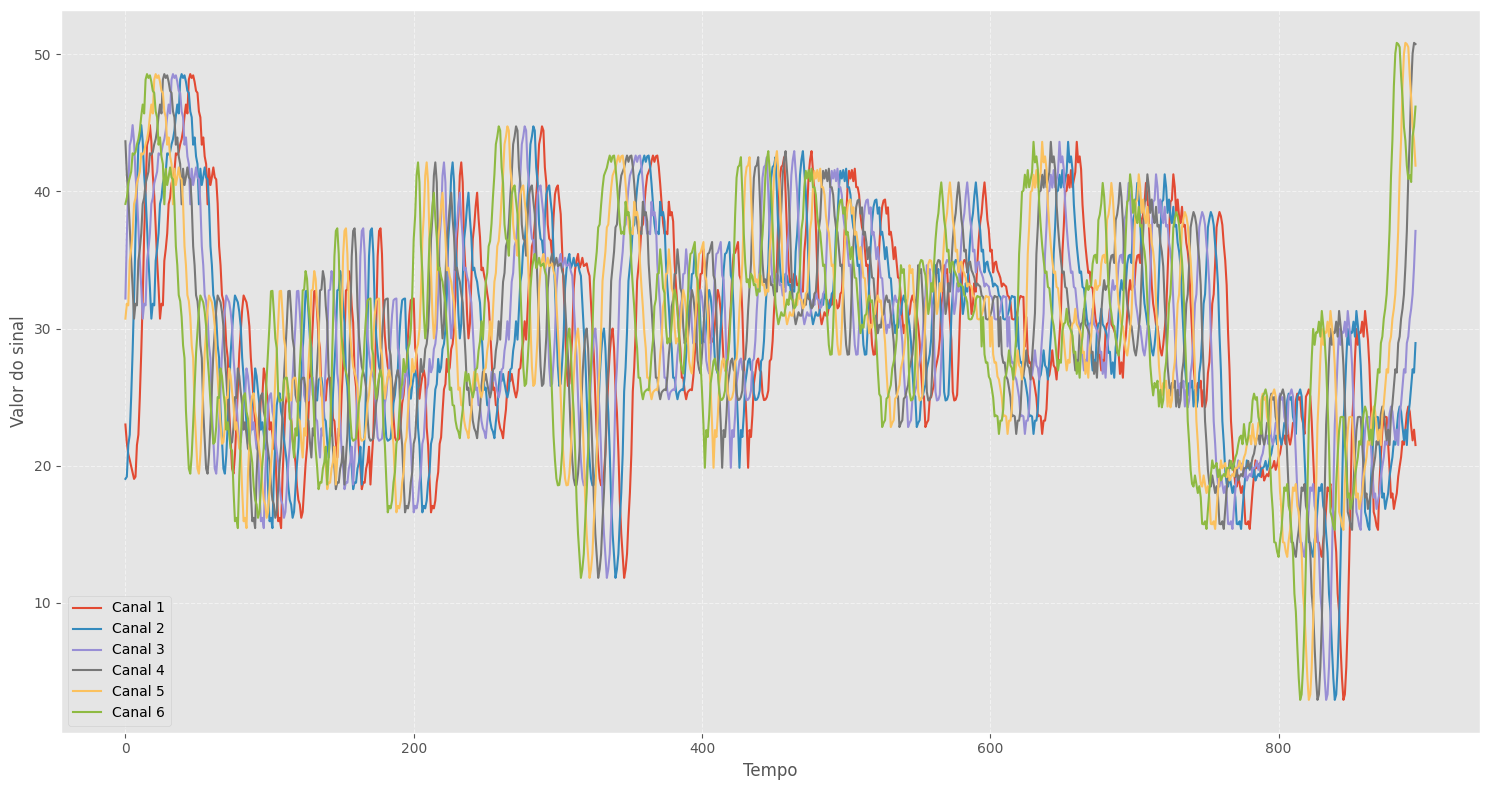

In [7]:
idx = 0  # índice da amostra desejada

plt.figure(figsize=(15, 8))
for i in range(n_canais):
    plt.plot(X_train[idx, i, :], label=f'Canal {i+1}')

# plt.title(f'Canais da Amostra {idx} - SELFREGULATIONSCP1', fontsize=14)
plt.xlabel('Tempo')
plt.ylabel('Valor do sinal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


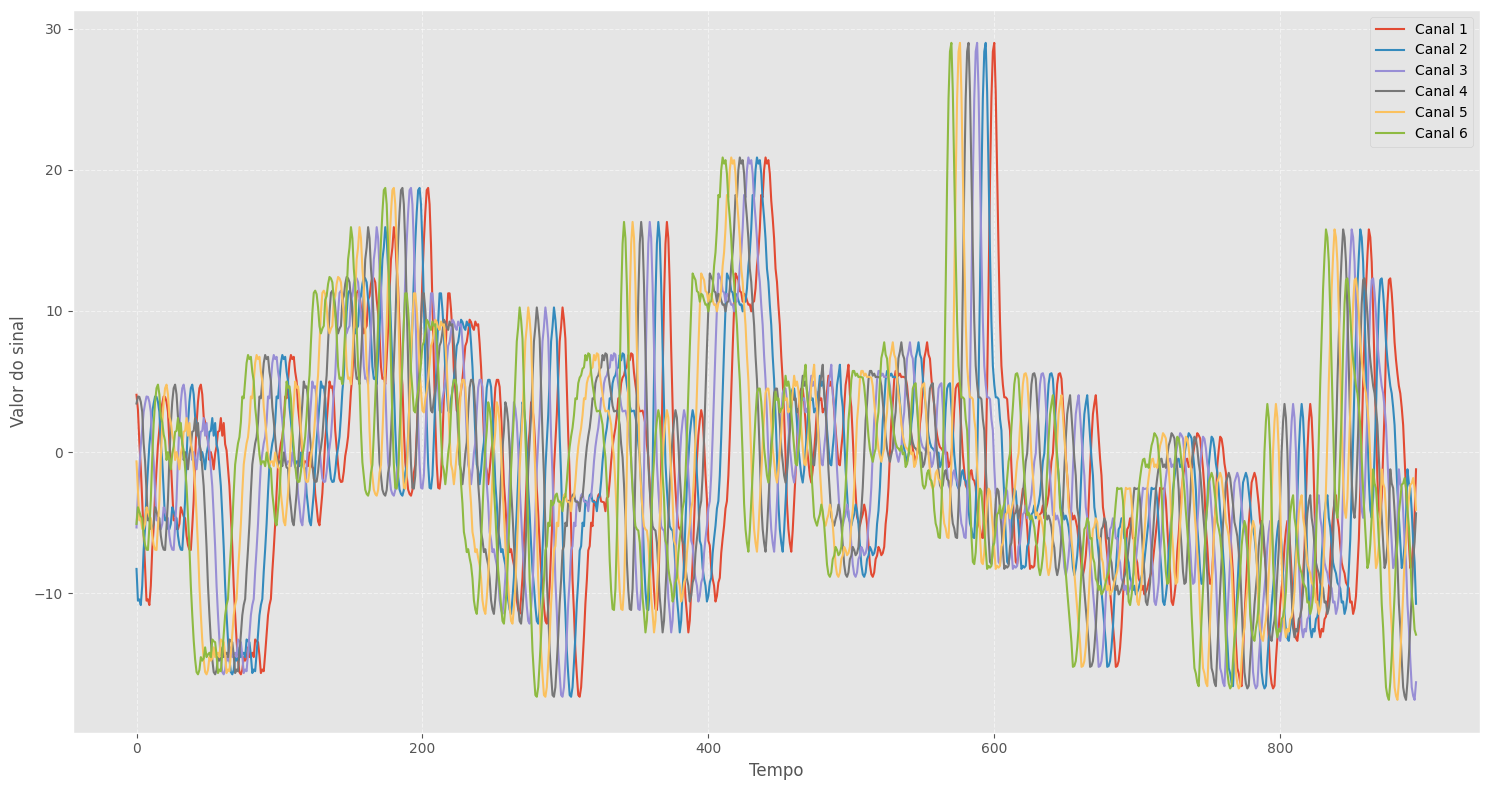

In [8]:
idx = 0  # índice da amostra desejada

plt.figure(figsize=(15, 8))
for i in range(n_canais):
    plt.plot(X_test[idx, i, :], label=f'Canal {i+1}')

# plt.title(f'Canais da Amostra {idx} - SELFREGULATIONSCP1', fontsize=14)
plt.xlabel('Tempo')
plt.ylabel('Valor do sinal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Fast Wavelet Transform

In [75]:
# --- Função para extrair features Wavelet 1D (coeficientes e estatísticas simples) ---
def extract_wavelet_features(X, wavelet='db4', level=3):
    """
    Extrai features baseadas na decomposição Wavelet dos sinais.

    Parâmetros:
    - X: array numpy de formato (n_amostras, n_canais, n_tempo)
    - wavelet: tipo de wavelet (ex.: 'db4')
    - level: nível de decomposição

    Retorna:
    - features: array (n_amostras, n_features)
    - feature_names: lista de nomes das features
    """
    dimension_names = ['Canal_1', 'Canal_2', 'Canal_3', 
                        'Canal_4', 'Canal_5', 'Canal_6']
    
    features = []
    feature_names = []

    for i in range(X.shape[0]):  # para cada amostra
        sample_features = []

        for dim in range(X.shape[1]):  # para cada dimensão (canal EEG)
            coeffs = pywt.wavedec(X[i, dim, :], wavelet, level=level)

            for j, coef in enumerate(coeffs):
                # estatísticas básicas dos coeficientes
                sample_features.append(np.mean(coef))
                sample_features.append(np.std(coef))
                sample_features.append(np.median(coef))
                sample_features.append(np.max(coef))
                sample_features.append(np.min(coef))

                # apenas uma vez, monta os nomes das features
                if i == 0:
                    base_name = f'{dimension_names[dim]}_coef{j}_'
                    feature_names += [
                        base_name + stat for stat in ['mean', 'std', 'median', 'max', 'min']
                    ]

        features.append(sample_features)

    return np.array(features), feature_names

In [76]:
X_train_feat, feature_names = extract_wavelet_features(X_train)
X_test_feat, _ = extract_wavelet_features(X_test)

## Pipeline de modelos e otimização com Optuna

In [54]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import TimeSeriesSplit

def objective(trial, model_name):
    if model_name == 'random_forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)
        max_depth = trial.suggest_int('max_depth', 5, 50)
        min_samples_split = trial.suggest_int('min_samples_split', 20, 300)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 20, 300)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

        clf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
        )

    elif model_name == 'lightgbm':
        num_leaves = trial.suggest_int('num_leaves', 4, 64)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.05)
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)
        max_depth = trial.suggest_int('max_depth', 5, 50)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 300)

        clf = LGBMClassifier(
            boosting_type='goss',
            num_leaves=num_leaves,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_child_samples=min_child_samples,
            random_state=42,
            n_jobs=-1
        )

    elif model_name == 'xgboost':
        max_depth = trial.suggest_int('max_depth', 5, 50)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.05)
        n_estimators = trial.suggest_int('n_estimators', 50, 1000)

        clf = XGBClassifier(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            eval_metric='logloss',
            random_state=42,
            n_jobs=-1
        )

    elif model_name == 'svm':
        C = trial.suggest_float('C', 1e-4, 1000, log=True)
        gamma = trial.suggest_float('gamma', 1e-5, 10.0, log=True)
        kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
        degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3

        clf = SVC(
            C=C,
            gamma=gamma,
            kernel=kernel,
            degree=degree,
            probability=True,
            random_state=42
        )

    elif model_name == 'logistic_regression':
        C = trial.suggest_float('C', 1e-4, 1000, log=True)
        penalty = trial.suggest_categorical('penalty', ['l2'])

        clf = LogisticRegression(
            C=C,
            penalty=penalty,
            max_iter=1000,
            random_state=42
        )

    else:
        raise ValueError('Unknown model')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        clf, X_train_feat, y_train, 
        scoring='average_precision', cv=cv, n_jobs=-1
    )

    trial.set_user_attr("std_pr_auc", np.std(scores))

    return np.mean(scores)


## Otimização para todos os modelos

In [55]:
models = ['random_forest', 'lightgbm', 'xgboost', 'svm', 'logistic_regression']
best_models = {}
studies = {}
results = []

sampler = TPESampler(seed=42)

for model in models:
    print(f'Optimizing {model}...')
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(lambda trial: objective(trial, model), n_trials=100)

    print(f'Best params for {model}: {study.best_params}')
    best_models[model] = study.best_params
    studies[model] = study

    for t in study.trials:
        results.append({
            'model': model,
            'trial': t.number,
            'value_mean': t.value,
            'value_std': t.user_attrs.get("std_pr_auc")
        })

df_results = pd.DataFrame(results)
print(df_results)

[I 2025-06-07 14:19:52,616] A new study created in memory with name: no-name-9aa41027-f515-42c6-9d39-43b85d4c5387


Optimizing random_forest...


[I 2025-06-07 14:19:58,170] Trial 0 finished with value: 0.49622641509433957 and parameters: {'n_estimators': 406, 'max_depth': 48, 'min_samples_split': 225, 'min_samples_leaf': 188, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.49622641509433957.
[I 2025-06-07 14:19:58,828] Trial 1 finished with value: 0.49622641509433957 and parameters: {'n_estimators': 105, 'max_depth': 44, 'min_samples_split': 188, 'min_samples_leaf': 218, 'max_features': 'log2'}. Best is trial 0 with value: 0.49622641509433957.
[I 2025-06-07 14:20:03,723] Trial 2 finished with value: 0.816519644031737 and parameters: {'n_estimators': 841, 'max_depth': 14, 'min_samples_split': 71, 'min_samples_leaf': 71, 'max_features': 'log2'}. Best is trial 2 with value: 0.816519644031737.
[I 2025-06-07 14:20:06,797] Trial 3 finished with value: 0.49622641509433957 and parameters: {'n_estimators': 460, 'max_depth': 18, 'min_samples_split': 191, 'min_samples_leaf': 59, 'max_features': 'log2'}. Best is trial 2 with value: 

Best params for random_forest: {'n_estimators': 371, 'max_depth': 43, 'min_samples_split': 71, 'min_samples_leaf': 34, 'max_features': 'sqrt'}
Optimizing lightgbm...


[I 2025-06-07 14:28:31,700] Trial 0 finished with value: 0.8241188066478202 and parameters: {'num_leaves': 27, 'learning_rate': 0.013640316685517405, 'n_estimators': 838, 'max_depth': 21, 'min_child_samples': 98}. Best is trial 0 with value: 0.8241188066478202.
[I 2025-06-07 14:28:31,997] Trial 1 finished with value: 0.49622641509433957 and parameters: {'num_leaves': 37, 'learning_rate': 0.007132118826240656, 'n_estimators': 812, 'max_depth': 8, 'min_child_samples': 297}. Best is trial 0 with value: 0.8241188066478202.
[I 2025-06-07 14:28:32,079] Trial 2 finished with value: 0.49622641509433957 and parameters: {'num_leaves': 51, 'learning_rate': 0.010015912508555203, 'n_estimators': 55, 'max_depth': 42, 'min_child_samples': 218}. Best is trial 0 with value: 0.8241188066478202.
[I 2025-06-07 14:28:32,277] Trial 3 finished with value: 0.8842310710472837 and parameters: {'num_leaves': 48, 'learning_rate': 0.038586390299628695, 'n_estimators': 120, 'max_depth': 21, 'min_child_samples': 52}

Best params for lightgbm: {'num_leaves': 57, 'learning_rate': 0.029370350475235136, 'n_estimators': 104, 'max_depth': 22, 'min_child_samples': 27}
Optimizing xgboost...


[I 2025-06-07 14:29:37,188] Trial 0 finished with value: 0.8981457039238713 and parameters: {'max_depth': 18, 'learning_rate': 0.00814494223397482, 'n_estimators': 934}. Best is trial 0 with value: 0.8981457039238713.
[I 2025-06-07 14:29:47,474] Trial 1 finished with value: 0.8935029850299617 and parameters: {'max_depth': 42, 'learning_rate': 0.03170684744987013, 'n_estimators': 878}. Best is trial 0 with value: 0.8981457039238713.
[I 2025-06-07 14:30:07,524] Trial 2 finished with value: 0.8978247841723647 and parameters: {'max_depth': 41, 'learning_rate': 0.009409845938413187, 'n_estimators': 898}. Best is trial 0 with value: 0.8981457039238713.
[I 2025-06-07 14:30:16,023] Trial 3 finished with value: 0.8950999761049172 and parameters: {'max_depth': 29, 'learning_rate': 0.04039126374268672, 'n_estimators': 902}. Best is trial 0 with value: 0.8981457039238713.
[I 2025-06-07 14:30:28,453] Trial 4 finished with value: 0.8623095906435895 and parameters: {'max_depth': 19, 'learning_rate': 

Best params for xgboost: {'max_depth': 22, 'learning_rate': 0.028305273786980136, 'n_estimators': 490}
Optimizing svm...


[I 2025-06-07 14:46:30,067] Trial 1 finished with value: 0.49622641509433957 and parameters: {'C': 0.000181221045447858, 'gamma': 0.04543452623910878, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7971018239063838.
[I 2025-06-07 14:46:30,138] Trial 2 finished with value: 0.6688359849769983 and parameters: {'C': 227.96134031070432, 'gamma': 0.0002737608521191864, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.7971018239063838.
[I 2025-06-07 14:46:30,313] Trial 3 finished with value: 0.49622641509433957 and parameters: {'C': 0.004947512505081406, 'gamma': 0.10784829520110376, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7971018239063838.
[I 2025-06-07 14:46:30,499] Trial 4 finished with value: 0.49622641509433957 and parameters: {'C': 0.037538933422125484, 'gamma': 0.06220638781359815, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7971018239063838.
[I 2025-06-07 14:46:30,554] Trial 5 finished with value: 0.5991738579150651 and parameters: {'C': 70.3262514472822, 'gamma': 0.00

Best params for svm: {'C': 0.004886938163557601, 'gamma': 8.67173345040493e-05, 'kernel': 'poly', 'degree': 3}
Optimizing logistic_regression...


[I 2025-06-07 14:48:47,724] Trial 0 finished with value: 0.8118297623532748 and parameters: {'C': 190.7700992605524, 'penalty': 'l2'}. Best is trial 0 with value: 0.8118297623532748.
[I 2025-06-07 14:48:48,312] Trial 1 finished with value: 0.8185517829136657 and parameters: {'C': 200.87523606336768, 'penalty': 'l2'}. Best is trial 1 with value: 0.8185517829136657.
[I 2025-06-07 14:48:48,818] Trial 2 finished with value: 0.8399198100556303 and parameters: {'C': 2.7021546495517854, 'penalty': 'l2'}. Best is trial 2 with value: 0.8399198100556303.
[I 2025-06-07 14:48:49,272] Trial 3 finished with value: 0.8925364309876777 and parameters: {'C': 0.0236161194792022, 'penalty': 'l2'}. Best is trial 3 with value: 0.8925364309876777.
[I 2025-06-07 14:48:49,677] Trial 4 finished with value: 0.8926297605180069 and parameters: {'C': 0.027827040640167708, 'penalty': 'l2'}. Best is trial 4 with value: 0.8926297605180069.
[I 2025-06-07 14:48:50,089] Trial 5 finished with value: 0.8198755978051556 and

Best params for logistic_regression: {'C': 0.03228531275725991, 'penalty': 'l2'}
                   model  trial  value_mean  value_std
0          random_forest      0    0.496226   0.004622
1          random_forest      1    0.496226   0.004622
2          random_forest      2    0.816520   0.039018
3          random_forest      3    0.496226   0.004622
4          random_forest      4    0.496226   0.004622
..                   ...    ...         ...        ...
495  logistic_regression     95    0.893027   0.048031
496  logistic_regression     96    0.892630   0.050412
497  logistic_regression     97    0.892562   0.048936
498  logistic_regression     98    0.892802   0.051630
499  logistic_regression     99    0.890736   0.053064

[500 rows x 4 columns]


In [56]:
df_results.head()

,model,trial,value_mean,value_std
0,random_forest,0,0.496226,0.004622
1,random_forest,1,0.496226,0.004622
2,random_forest,2,0.816520,0.039018
3,random_forest,3,0.496226,0.004622
4,random_forest,4,0.496226,0.004622


In [57]:
df_results.to_csv('results_selfregulation.csv', index=False)

In [58]:
# Mapeamento dos nomes dos modelos
model_name_map = {
    'random_forest': 'RF',
    'lightgbm': 'LGBM',
    'xgboost': 'XGB',
    'svm': 'SVM',
    'logistic_regression': 'LR'
}

# Aplica o mapeamento no dataframe
df_results["model_short"] = df_results["model"].map(model_name_map)


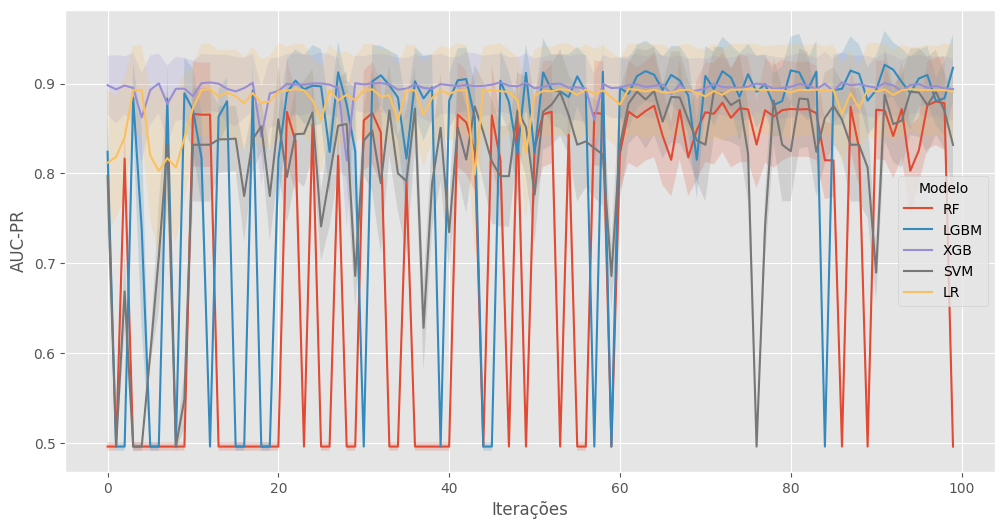

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_results, 
    x="trial", 
    y="value_mean", 
    hue="model_short", 
    # marker="o"
)

for model in df_results["model_short"].unique():
    subset = df_results[df_results["model_short"] == model]
    plt.fill_between(
        subset["trial"],
        subset["value_mean"] - subset["value_std"],
        subset["value_mean"] + subset["value_std"],
        alpha=0.2
    )

# plt.title("Desempenho dos Modelos ao longo das Interações")
plt.xlabel("Iterações")
plt.ylabel("AUC-PR")
plt.legend(title="Modelo")
plt.grid(True)

## Avaliação Final

In [77]:
models = ['random_forest', 'lightgbm', 'xgboost', 'svm', 'logistic_regression']
model_names = {'random_forest': 'RF', 'lightgbm': 'LGBM', 'xgboost': 'XGB', 'svm': 'SVM', 'logistic_regression': 'LR'}


In [78]:
import os
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score, 
    roc_auc_score, confusion_matrix
)


os.makedirs('models', exist_ok=True)

# Função para instanciar os modelos com os melhores hiperparâmetros
def train_best_model(model_name, params):
    if model_name == 'random_forest':
        model = RandomForestClassifier(**params, random_state=42)
    elif model_name == 'lightgbm':
        model = LGBMClassifier(**params, boosting_type='goss', random_state=42)
    elif model_name == 'xgboost':
        model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == 'svm':
        model = SVC(**params, probability=True, random_state=42)
    elif model_name == 'logistic_regression':
        model = LogisticRegression(**params, max_iter=1000, random_state=42)
    else:
        raise ValueError('Unknown model')
    return model


# Renomeação dos modelos
model_names_map = {
    'random_forest': 'RF',
    'lightgbm': 'LGBM',
    'xgboost': 'XGB',
    'svm': 'SVM',
    'logistic_regression': 'LR'
}

results = []

# Loop de treinamento, salvamento e avaliação
for model_name, params in best_models.items():
    print(f'Training {model_name} with best hyperparameters...')

    model = train_best_model(model_name, params)
    model.fit(X_train_feat, y_train)

    # Salvar modelo
    filename = f'models/{model_names_map[model_name]}_model.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

    print(f'Modelo {model_names_map[model_name]} salvo em {filename}')

    # Previsões
    y_pred = model.predict(X_test_feat)
    y_proba = model.predict_proba(X_test_feat)[:, 1] if hasattr(model, "predict_proba") else None

    # Matriz de confusão para especificidade
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Somente para problema binário

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Métricas
    metrics = {
        'Model': model_names_map[model_name],
        'F1_Score': f1_score(y_test, y_pred, average='binary'),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred, average='binary'),
        'Precision': precision_score(y_test, y_pred, average='binary'),
        'ROC_AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'Specificity': specificity
    }
    results.append(metrics)

# Resultado final
df_results = pd.DataFrame(results)
print(df_results)

Training random_forest with best hyperparameters...
Modelo RF salvo em models/RF_model.pkl
Training lightgbm with best hyperparameters...
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 133, number of negative: 135
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10808
[LightGBM] [Info] Number of data points in the train set: 268, number of used features: 120
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.4

c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [79]:
df_results

,Model,F1_Score,Accuracy,Recall,Precision,ROC_AUC,Specificity
0,RF,0.811429,0.774744,0.972603,0.696078,0.925822,0.578231
1,LGBM,0.807799,0.764505,0.993151,0.680751,0.874988,0.537415
2,XGB,0.800000,0.761092,0.958904,0.686275,0.864272,0.564626
3,SVM,0.866242,0.856655,0.931507,0.809524,0.906905,0.782313
4,LR,0.848684,0.843003,0.883562,0.816456,0.905973,0.802721


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


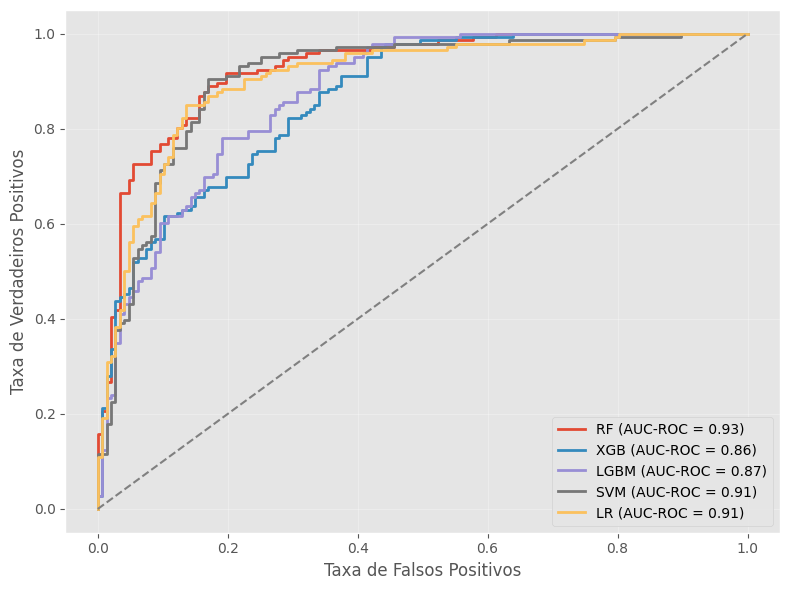

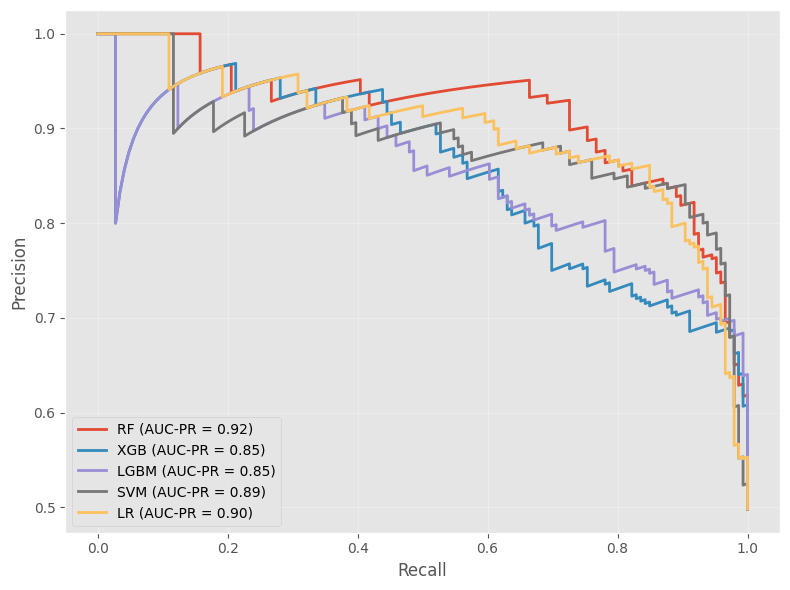

In [80]:
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Mapear os nomes dos arquivos dos modelos
model_files = {
    'RF': 'models/RF_model.pkl',
    'XGB': 'models/XGB_model.pkl',
    'LGBM': 'models/LGBM_model.pkl',
    'SVM': 'models/SVM_model.pkl',
    'LR': 'models/LR_model.pkl'
}

# Armazenar predições e métricas por modelo
model_scores = {}

for model_name, file_name in model_files.items():
    with open(file_name, 'rb') as file:
        model = pickle.load(file)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_feat)[:, 1]
    else:
        raise ValueError(f'Model {model_name} does not support predict_proba.')

    # Calcular métricas
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_test, y_score)
    pr_auc = average_precision_score(y_test, y_score)

    # Salvar tudo em um dicionário
    model_scores[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'pr_auc': pr_auc
    }

# ---------------------
# Gráfico ROC
# ---------------------
plt.figure(figsize=(8, 6))

for model_name, scores in model_scores.items():
    plt.plot(scores['fpr'], scores['tpr'], lw=2,
             label=f'{model_name} (AUC-ROC = {scores["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
# plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------
# Gráfico Precision-Recall
# ---------------------
plt.figure(figsize=(8, 6))

for model_name, scores in model_scores.items():
    plt.plot(scores['recall'], scores['precision'], lw=2,
             label=f'{model_name} (AUC-PR = {scores["pr_auc"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Explicabilidade 

In [81]:
with open('models/RF_model.pkl', 'rb') as file:
    rf_model = pickle.load(file)

with open('models/XGB_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('models/LGBM_model.pkl', 'rb') as file:
    lgbm_model = pickle.load(file)

with open('models/SVM_model.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('models/LR_model.pkl', 'rb') as file:
    lr_model = pickle.load(file)

In [82]:
lr_model

LogisticRegression(C=0.03228531275725991, max_iter=1000, random_state=42)

In [83]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.028305273786980136, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=22, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=490, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [84]:
lgbm_model

LGBMClassifier(boosting_type='goss', learning_rate=0.029370350475235136,
               max_depth=22, min_child_samples=27, n_estimators=104,
               num_leaves=57, random_state=42)

In [85]:
svm_model

SVC(C=0.004886938163557601, gamma=8.67173345040493e-05, kernel='poly',
    probability=True, random_state=42)

In [86]:
rf_model

RandomForestClassifier(max_depth=43, min_samples_leaf=34, min_samples_split=71,
                       n_estimators=371, random_state=42)

In [87]:
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_feat)


In [88]:
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values[1]

print("Shape shap_values_class1:", shap_values_class1.shape)
print("Shape X_test_feat:", X_test_feat.shape)
print("Número de feature_names:", len(feature_names))

Shape shap_values_class1: (293, 120)
Shape X_test_feat: (293, 120)
Número de feature_names: 120


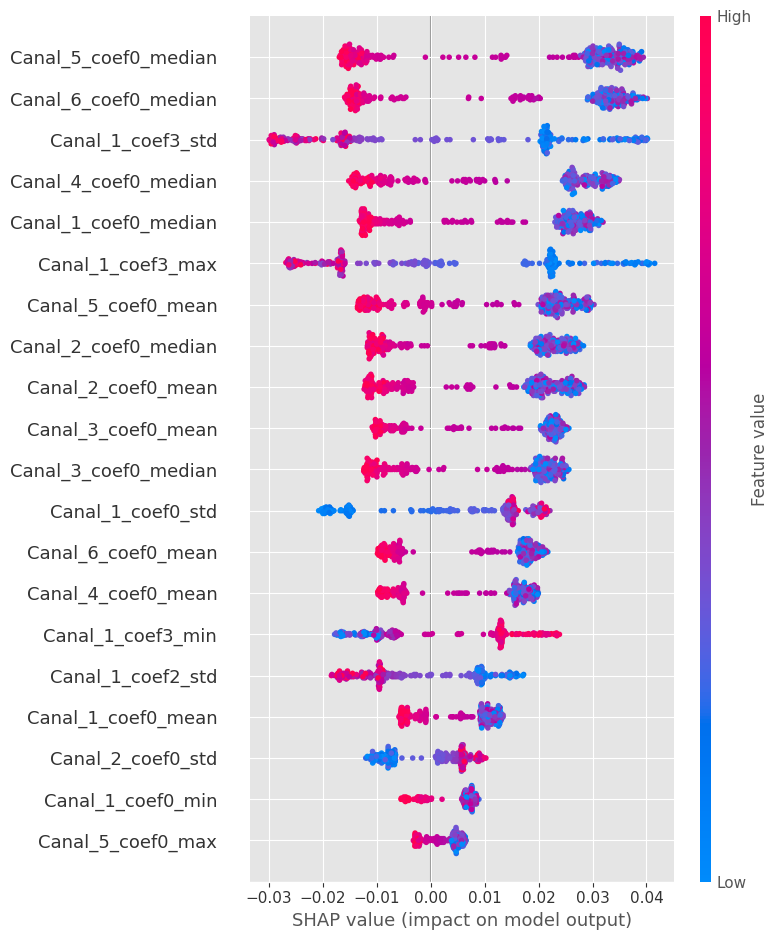

In [89]:
shap.summary_plot(shap_values_class1, X_test_feat, feature_names=feature_names, max_display=20)

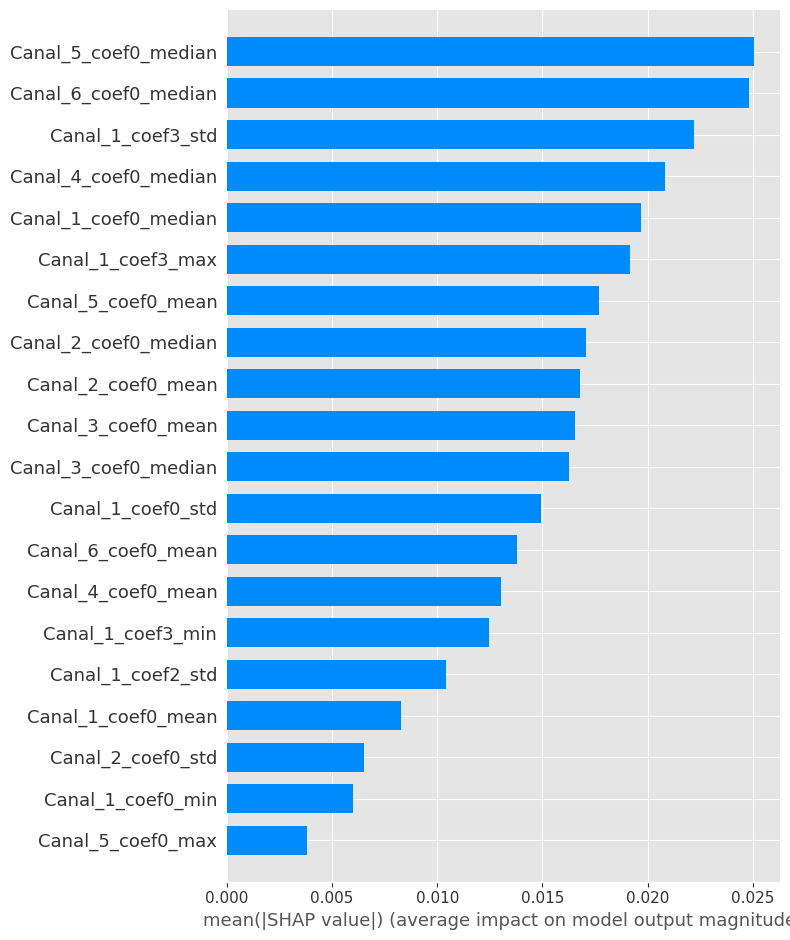

In [90]:
shap.summary_plot(shap_values_class1, X_test_feat, feature_names=feature_names, plot_type="bar", max_display=20)